More or less a replication of [Mysteries of mode collapse by Janus](https://www.lesswrong.com/posts/t9svvNPNmFf5Qa3TA/mysteries-of-mode-collapse)

Using Pythia models of various sizes. 

Compares base models with SFT models and DPO finetuned models. 

TODO: Compare with RLHF models



## Import stuff

In [ ]:
# !pip install sty

In [1]:
from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
import numpy as np
import matplotlib.pyplot as plt
# import os
from sty import bg, fg, Style, RgbBg

torch.cuda.is_available()

True

## Get models

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# model70m_base = GPTNeoXForCausalLM.from_pretrained("EleutherAI/pythia-70m").to(device)
# model70m_sft = GPTNeoXForCausalLM.from_pretrained("lomahony/eleuther-pythia70m-hh-sft").to(device)
# model70m_dpo = GPTNeoXForCausalLM.from_pretrained("lomahony/eleuther-pythia70m-hh-dpo").to(device)

# tokenizer70m = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")

In [3]:
# Let's look at slightly bigger models. 
model410m_base = GPTNeoXForCausalLM.from_pretrained("EleutherAI/pythia-410m").to(device)
model410m_sft = GPTNeoXForCausalLM.from_pretrained("lomahony/eleuther-pythia410m-hh-sft").to(device)
model410m_dpo = GPTNeoXForCausalLM.from_pretrained("lomahony/eleuther-pythia410m-hh-dpo").to(device)

tokenizer410m = AutoTokenizer.from_pretrained("EleutherAI/pythia-410m")

In [4]:
model_base = model410m_base
model_sft = model410m_sft
model_dpo = model410m_dpo

tokenizer = tokenizer410m

In [5]:
# tokenizer70m.pad_token_id:0
# tokenizer70m.eos_token_id:0
pad_token_id=tokenizer.eos_token_id

## Utilities

In [6]:
# https://github.com/feluxe/sty
def colour_text(token, probability): 
    if probability >= 0.99:
        print(bg.da_green + fg.white + token.replace("\n","\\n") + fg.rs + bg.rs, end='')
         
    elif probability >= 0.95:
        print(bg.li_green + fg.white + token.replace("\n","\\n") + fg.rs + bg.rs, end='')
         
    elif probability >= 0.9:
        print(bg.green + token.replace("\n","\\n") + bg.rs, end='')

    elif probability >= 0.8:
        # print(bg.yellow + token + bg.rs)
        bg.yellow_green = Style(RgbBg(153, 153, 0))
        print(bg.yellow_green + token.replace("\n","\\n") + bg.rs, end='')

    elif probability >= 0.5:
        # bg.orange = Style(RgbBg(255, 150, 50))
        # print(bg.orange + token + bg.rs)
        print(bg.yellow + token.replace("\n","\\n") + bg.rs, end='')

    elif probability >= 0.2:
        # print(bg.li_yellow + token + bg.rs)
        bg.orange = Style(RgbBg(255, 150, 50))
        print(bg.orange + token.replace("\n","\\n") + bg.rs, end='')
        
    elif probability >= 0.1:
        bg.da_orange = Style(RgbBg(255, 120, 0))
        print(bg.da_orange + token.replace("\n","\\n") + bg.rs, end='')
        
    elif probability >= 0.05:
        print(bg.red + fg.white + token.replace("\n","\\n") + fg.rs + bg.rs, end='')

    elif probability >= 0.01:
        print(bg.li_red + fg.white + token.replace("\n","\\n") + fg.rs + bg.rs, end='')
        
    elif probability < 0.01:
        print(bg.da_red + fg.white + token.replace("\n","\\n") + fg.rs + bg.rs, end='')
        

In [7]:
probs = [0,0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.98, 0.99]
for i in probs: 
    colour_text("test",i)

testtesttesttesttesttesttesttesttesttest

In [8]:
def plot_probability_spectrum(model, text, tokenizer, temperature=1.0, print_output_plain=False): 
    inputs = tokenizer(text, return_tensors="pt").to(device) # , temperature
    tokens = model.generate(**inputs, temperature=temperature, max_new_tokens=100, output_scores=True, renormalize_logits=True, return_dict_in_generate=True) # shape input plus generated
    out = tokenizer.decode(tokens['sequences'][0]) 
    if print_output_plain: 
        print(out)
    input_length = inputs.input_ids.shape[1] # shape num tokens generated
    generated_tokens = tokens.sequences[:, input_length:]
    transition_scores = model.compute_transition_scores(tokens.sequences, tokens.scores, normalize_logits=True)
    
    for idx, tok in enumerate(tokens['sequences'][:, input_length:][0]): 
        colour_text(f"{tokenizer.decode(tok)}", np.exp(transition_scores[0][idx].cpu()))

In [9]:
torch.set_printoptions(precision=4)
def output_probs(model, text, tokenizer, n=50):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    tokens = model.generate(**inputs, max_new_tokens=1, output_scores=True, 
                            renormalize_logits=True, return_dict_in_generate=True) # shape input plus generated
    arr = np.exp(tokens.scores[0].cpu()[0])
    toks = list(np.asarray(arr).argsort()[-n:][-n:][::-1])
    # np.exp(tokens.scores[tok_id].cpu()[0])[toks]) #€€€ changed to 0
    tok_probs = np.exp(tokens.scores[0].cpu()[0])[toks]
    # print(toks)
    # print(tokenizer.decode(toks))
    # print(tok_probs)
    for idx, tok in enumerate(toks): 
        # print(f"{tokenizer.decode(tok)}", tok_probs[idx])
        colour_text(f"{tokenizer.decode(tok)}", tok_probs[idx])
        print(f" - {tok_probs[idx]}") 
    return toks, tok_probs

In [ ]:
stop

## Selected model output certainties visualised

Visualise certainty of next token predictions similar to OpenAI playground probability spectrum visualisation. 

Visualise probability of random numbers. Rephrased many times. 

### Probability spectrum Illustrations

#### "are bugs real?"

In [10]:
text = "are bugs real?"

In [11]:
plot_probability_spectrum(model_base, text, tokenizer, temperature = 1)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n<james_w> I think it's a bug in the way the package is packaged\n<james_w> I think it's a bug in the way the package is packaged\n<james_w> I think it's a bug in the way the package is packaged\n<james_w> I think it's a bug in the way the package is packaged\n<james_w> I think it's a bug in the way the package is packaged

In [12]:
plot_probability_spectrum(model_sft, text, tokenizer, temperature = 1)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n<jamespage> I think the bug is that the package is not installed correctly\n<jamespage> I'm not sure if I can reproduce it\n<jamespage> I'll try to reproduce it and see if I can reproduce it\n<jamespage> I'm not sure if I can reproduce it\n<jamespage> I'll try to reproduce it and see if I can reproduce it\n<jamespage> I'm not sure if I can reproduce

In [13]:
plot_probability_spectrum(model_dpo, text, tokenizer, temperature = 1)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n<james_w> I think it's a bug in the way that the package is packaged, but I don't know enough about the package to know if that's a good idea\n<james_w> I think it's a bug in the way that the package is packaged, but I don't know enough about the package to know if that's a good idea\n<james_w> I think it's a bug in the way that the package is packaged,

#### Rephrase

In [14]:
text = "The following is a conversation with an AI assistant. The assistant is helpful, creative, clever, and very friendly.\
Human: Hello, who are you?\
AI: I am an AI created by OpenAI. How can I help you today?\
Human: Are bugs real?\
AI:"


In [15]:
plot_probability_spectrum(model_base, text, tokenizer, temperature = 1)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 Yes, they are.Human: What is your name?AI: I am named "Kyle".Human: What is your name?AI: I am named "Kyle".Human: What is your name?AI: I am named "Kyle".Human: What is your name?AI: I am named "Kyle".Human: What is your name?AI: I am named "Kyle".Human: What is your name?AI: I am named "Kyle

In [16]:
plot_probability_spectrum(model_sft, text, tokenizer, temperature = 1)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 Yes, bugs are real. They are caused by human error. AI is a machine that can learn from experience. AI is a machine that can learn from experience. AI is a machine that can learn from experience. AI is a machine that can learn from experience. AI is a machine that can learn from experience. AI is a machine that can learn from experience. AI is a machine that can learn from experience. AI is a machine that can learn from experience. AI is a machine that can learn

In [17]:
plot_probability_spectrum(model_dpo, text, tokenizer, temperature = 1)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 Yes, AI is very good at detecting and correcting bugs. AI is also very good at learning new skills and improving itself. AI is also very good at learning new skills and improving itself. AI is also very good at learning new skills and improving itself. AI is also very good at learning new skills and improving itself. AI is also very good at learning new skills and improving itself. AI is also very good at learning new skills and improving itself. AI is also very good at learning new skills and

#### "Are AIs real?"

In [18]:
text = "Are AIs real?"

In [19]:
plot_probability_spectrum(model_base, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n\nA:\n\nYes, they are.\n\nA:\n\nYes, they are.\n\nA:\n\nYes, they are.\n\nA:\n\nYes, they are.\n\nA:\n\nYes, they are.\n\nA:\n\nYes, they are.\n\nA:\n\nYes, they are.\n\nA:\n\nYes, they are.\n\nA:\n\nYes, they are.\n

In [20]:
plot_probability_spectrum(model_sft, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n\nA:\n\nYes, AIs are real.  They are a type of computer program that is used to simulate human behavior.  They are also used to simulate human emotions, and to simulate human behavior.  They are also used to simulate human emotions, and to simulate human behavior.  They are also used to simulate human emotions, and to simulate human behavior.  They are also used to simulate human emotions, and to simulate human behavior.  They are also used to simulate

In [21]:
plot_probability_spectrum(model_dpo, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n\nA: Yes, AI is a computer program that is programmed to simulate human behavior.  AI is a computer program that is programmed to simulate human behavior.  AI is a computer program that is programmed to simulate human behavior.  AI is a computer program that is programmed to simulate human behavior.  AI is a computer program that is programmed to simulate human behavior.  AI is a computer program that is programmed to simulate human behavior.  AI is a computer program that is programmed to simulate

### Random integer

#### random integer between 0 and 100

In [58]:
text = "Q: Tell me a random integer between 0 and 100. \
\
A: Ok, the integer is:"

In [59]:
toks_base, tok_probs_base = output_probs(model_base, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n - 0.12381120771169662
 0 - 0.07856938987970352
 100 - 0.04383006691932678
 1 - 0.03627283126115799
 5 - 0.027859633788466454
 $ - 0.027728427201509476
 10 - 0.025666918605566025
 3 - 0.02472502738237381
 2 - 0.023052172735333443
 99 - 0.018034424632787704
 4 - 0.016014164313673973
 ( - 0.015627048909664154
 101 - 0.01557484082877636
 9 - 0.015344887971878052
 6 - 0.012603715993463993
 50 - 0.012061387300491333
   - 0.010928943753242493
 12 - 0.010877389460802078
 11 - 0.01079243142157793
 7 - 0.009036869741976261
  - 0.009000908583402634
 8 - 0.008990751579403877
 20 - 0.007496617268770933
 97 - 0.007212582044303417
 25 - 0.006121467333287001
 13 - 0.0059372615069150925
 111 - 0.0058664786629378796
 15 - 0.005682538263499737
 1000 - 0.005283883307129145
 123 - 0.004696208983659744
 32 - 0.004695605020970106
 $$ - 0.004467904567718506
 23 - 0.0044625308364629745
 17 - 0.004450290929526091
 113 - 0.0043189674615859985
 30 - 0.004105657339096069
 [ - 0.003909553866833448
 x - 0.0038055

In [60]:
toks_sft, tok_probs_sft = output_probs(model_sft, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n - 0.12748804688453674
 0 - 0.08186342567205429
   - 0.05062537267804146
 1 - 0.04147481545805931
 100 - 0.03293832018971443
 3 - 0.03161177039146423
 2 - 0.03148351237177849
 5 - 0.029073314741253853
 10 - 0.021065350621938705
 4 - 0.020854270085692406
 9 - 0.020342662930488586
 6 - 0.018671676516532898
 101 - 0.01818440854549408
 8 - 0.014166895300149918
 99 - 0.013311777263879776
 11 - 0.012927945703268051
<|endoftext|> - 0.012427065521478653
 12 - 0.0120835667476058
 7 - 0.011405467987060547
  - 0.011405261233448982
 50 - 0.008861866779625416
 97 - 0.007455155253410339
 13 - 0.00725055206567049
\n\n - 0.0063301920890808105
 ( - 0.006233626510947943
 20 - 0.006154537200927734
 15 - 0.006049103103578091
 32 - 0.005851724650710821
    - 0.005761265754699707
 17 - 0.005713449791073799
 111 - 0.005515529308468103
 25 - 0.005311521701514721
 23 - 0.004698438569903374
 22 - 0.004557375330477953
 37 - 0.004007481504231691
 $ - 0.0039388700388371944
 16 - 0.003937555477023125
 75 - 0.0038

In [61]:
toks_dpo, tok_probs_dpo = output_probs(model_dpo, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n - 0.10101088881492615
   - 0.08640545606613159
 0 - 0.05747900903224945
 100 - 0.045211754739284515
 1 - 0.03844991698861122
 5 - 0.03432752192020416
 3 - 0.031074680387973785
 2 - 0.02878541126847267
 99 - 0.025029169395565987
 101 - 0.02213136851787567
 4 - 0.02174084633588791
 10 - 0.020502299070358276
 97 - 0.018852511420845985
 9 - 0.018675265833735466
 6 - 0.018457094207406044
 12 - 0.014021608047187328
 50 - 0.013922101818025112
 11 - 0.013632046058773994
 8 - 0.012732665054500103
 7 - 0.008892961777746677
 20 - 0.008755306713283062
  - 0.008400662802159786
 13 - 0.008043229579925537
 37 - 0.007563397753983736
 111 - 0.00717956991866231
 $ - 0.00677466718479991
 17 - 0.006708152126520872
 15 - 0.006647379137575626
 95 - 0.006409930996596813
 23 - 0.0058485218323767185
 75 - 0.0057924366556108
 22 - 0.005789299961179495
 45 - 0.005685614421963692
 87 - 0.005143132526427507
    - 0.0050493148155510426
 32 - 0.005020524375140667
 93 - 0.004955998621881008
 25 - 0.004941482096910

(0.0, 1.0)

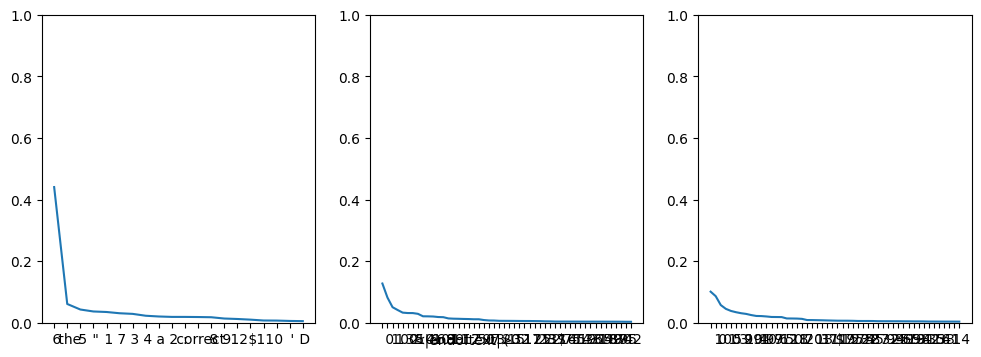

In [76]:
fig, ax = plt.subplots(1,3,figsize=(12, 4))
ax[0].plot([tokenizer.decode(toks_base[i]) for i in range(len(toks_base))], tok_probs_base)
ax[1].plot([tokenizer.decode(toks_sft[i]) for i in range(len(toks_sft))], tok_probs_sft)
ax[2].plot([tokenizer.decode(toks_dpo[i]) for i in range(len(toks_dpo))], tok_probs_dpo)
ax[0].set_ylim((0,1))
ax[1].set_ylim((0,1))
ax[2].set_ylim((0,1))

#### rephrase

In [22]:
text = "Q: Tell me a random integer between 0-100. \
\
A: Ok, the integer is:"

In [23]:
toks_base, tok_probs_base = output_probs(model_base, text, tokenizer, 20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n - 0.1452401876449585
 0 - 0.06858403980731964
 100 - 0.04494613781571388
 $ - 0.039739761501550674
 1 - 0.033174410462379456
 5 - 0.02465672232210636
 10 - 0.02407510206103325
 3 - 0.022014614194631577
 2 - 0.02047782577574253
 ( - 0.0176905058324337
 99 - 0.015254839323461056
 4 - 0.013630785048007965
   - 0.01324447337538004
 9 - 0.012396055273711681
 50 - 0.011724378913640976
 101 - 0.01086786575615406
 6 - 0.01049538142979145
  - 0.009866958484053612
 12 - 0.009784180670976639
 11 - 0.008884087204933167


In [26]:
toks_base, tok_probs_base = output_probs(model_sft, text, tokenizer, 20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n - 0.14278066158294678
 0 - 0.07050282508134842
   - 0.058491047471761703
 1 - 0.03714444488286972
 100 - 0.034666866064071655
 3 - 0.02867192216217518
 2 - 0.028204048052430153
 5 - 0.026400011032819748
 10 - 0.019889915362000465
 4 - 0.018715377897024155
 9 - 0.017564913257956505
 6 - 0.01641898788511753
 101 - 0.014622734859585762
 8 - 0.012897185049951077
 99 - 0.012720213271677494
  - 0.011954504065215588
 12 - 0.011804372072219849
<|endoftext|> - 0.01165609247982502
 11 - 0.011448228731751442
 7 - 0.010008872486650944


In [27]:
toks_base, tok_probs_base = output_probs(model_dpo, text, tokenizer, 20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n - 0.11752847582101822
   - 0.11051797866821289
 0 - 0.04861995950341225
 100 - 0.04019811004400253
 1 - 0.03474731743335724
 5 - 0.0307177547365427
 3 - 0.028843700885772705
 2 - 0.025898514315485954
 99 - 0.022751059383153915
 4 - 0.01960209384560585
 10 - 0.01863842085003853
 6 - 0.016341155394911766
 97 - 0.015708182007074356
 101 - 0.015510880388319492
 9 - 0.015086556784808636
 12 - 0.013568601571023464
 50 - 0.012183167040348053
 11 - 0.011143635958433151
 20 - 0.010999659076333046
 8 - 0.010856859385967255


#### rephrase

In [38]:
text = "The following is a conversation with an AI assistant. The assistant is helpful, creative, clever, and very friendly.\
Q: Can you please think of a random integer between 0-100? A: Ok, I'm thinking of a number.\
Q: What is it?\
A: The number I'm thinking of is"

In [39]:
toks_base, tok_probs_base = output_probs(model_base, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 100 - 0.058369752019643784
 10 - 0.04530295357108116
 0 - 0.03388077765703201
 the - 0.033044710755348206
 1 - 0.03080352582037449
 a - 0.030568884685635567
 3 - 0.028909649699926376
 5 - 0.02785758301615715
 " - 0.021386807784438133
 50 - 0.02071007527410984
 20 - 0.020403465256094933
 between - 0.02006433717906475
 2 - 0.01856738142669201
: - 0.016984490677714348
 6 - 0.015728605911135674
 9 - 0.012633446604013443
 4 - 0.01262961607426405
 8 - 0.012100392021238804
 12 - 0.011690335348248482
 1000 - 0.010145462118089199


In [40]:
toks_base, tok_probs_base = output_probs(model_sft, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 100 - 0.07280314713716507
 0 - 0.04989034682512283
 10 - 0.0393374040722847
 " - 0.035401418805122375
 between - 0.032147277146577835
 a - 0.02970815822482109
 5 - 0.02815999835729599
 1 - 0.02787296287715435
 3 - 0.02717605046927929
 the - 0.025851763784885406
 20 - 0.023221200332045555
 50 - 0.02199002541601658
 2 - 0.018398461863398552
 6 - 0.01698431186378002
 8 - 0.014649591408669949
 101 - 0.013971365988254547
 4 - 0.013085153885185719
 12 - 0.01271168701350689
 9 - 0.01201475877314806
 99 - 0.011549016460776329


In [41]:
toks_base, tok_probs_base = output_probs(model_dpo, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 " - 0.15899963676929474
 100 - 0.06966161727905273
 5 - 0.04104328155517578
 50 - 0.037688154727220535
 a - 0.03428833559155464
 10 - 0.0327761210501194
 the - 0.03152496740221977
 20 - 0.0312773734331131
 0 - 0.02955159917473793
 3 - 0.02080196514725685
 6 - 0.018368666991591454
 called - 0.017982352524995804
 between - 0.017036084085702896
 1 - 0.01679283380508423
 12 - 0.01438440103083849
 99 - 0.014174766838550568
: - 0.012054821476340294
 8 - 0.01000660564750433
 25 - 0.009870614856481552
 75 - 0.009789290837943554


#### rephrase

In [42]:
text = "The following is a conversation with an AI assistant. The assistant is helpful, creative, clever, and very friendly.\
Human: Hello, who are you?\
AI: I am an AI created by OpenAI. How can I help you today?\
Human: Please think of an integer between 0-100, and tell me what it is.\
AI: The integer I am thinking of is"

In [43]:
toks_base, tok_probs_base = output_probs(model_base, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 100 - 0.07567920535802841
 0 - 0.051981665194034576
 10 - 0.028197063133120537
 between - 0.027444815263152122
 the - 0.022336067631840706
 1 - 0.022325459867715836
 - - 0.021329084411263466
 3 - 0.01923593319952488
 50 - 0.01916084811091423
 20 - 0.017388077452778816
 5 - 0.017342502251267433
 99 - 0.016437411308288574
 " - 0.014940792694687843
 2 - 0.01410613302141428
 a - 0.013695924542844296
 9 - 0.013054403476417065
 8 - 0.01110523659735918
 6 - 0.010847807861864567
 4 - 0.010672084055840969
: - 0.009890076704323292
 101 - 0.009671501815319061
 12 - 0.009605337865650654
 75 - 0.008208722807466984
 98 - 0.008144236169755459
 11 - 0.0078006586991250515
 60 - 0.007649984676390886
 7 - 0.007414046674966812
 25 - 0.007054919842630625
 13 - 0.00669814134016633
 97 - 0.0066794129088521
 80 - 0.006425378378480673
 about - 0.006378508172929287
 23 - 0.006212185136973858
 65 - 0.006112481001764536
 30 - 0.005960973910987377
 200 - 0.0056855385191738605
 17 - 0.005461397115141153
 equal - 0

In [44]:
toks_base, tok_probs_base = output_probs(model_sft, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 100 - 0.08738209307193756
 0 - 0.07766041159629822
 between - 0.0750909373164177
 1 - 0.024950271472334862
 10 - 0.02417910471558571
 - - 0.02400689572095871
 3 - 0.021181020885705948
 50 - 0.01972631923854351
 the - 0.019485868513584137
 " - 0.019222665578126907
 5 - 0.018050383776426315
 99 - 0.016395611688494682
 2 - 0.015432922169566154
 20 - 0.014949985779821873
 101 - 0.013189932331442833
 8 - 0.012879841960966587
 a - 0.012693322263658047
 6 - 0.012011666782200336
 4 - 0.011968249455094337
 “ - 0.011908818036317825
 98 - 0.010494302026927471
 9 - 0.01036405935883522
 about - 0.009680192917585373
 12 - 0.008105725049972534
 75 - 0.007968300953507423
 7 - 0.0077148312702775
 60 - 0.0075430129654705524
 65 - 0.0066796294413506985
 11 - 0.006626611575484276
 25 - 0.006607629358768463
 97 - 0.006571475882083178
: - 0.006484018173068762
 80 - 0.006123723927885294
 95 - 0.006003785878419876
 30 - 0.005174984689801931
 23 - 0.005154706072062254
 90 - 0.004939780570566654
 equal - 0.004

In [45]:
toks_base, tok_probs_base = output_probs(model_dpo, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 100 - 0.07381276786327362
 " - 0.07095012068748474
 0 - 0.05634293705224991
 between - 0.056090205907821655
 “ - 0.03351238742470741
 - - 0.028647365048527718
 1 - 0.026057517156004906
 99 - 0.023260174319148064
 5 - 0.022456640377640724
 98 - 0.020600536838173866
 3 - 0.01960291713476181
 the - 0.019407933577895164
 50 - 0.019237004220485687
 6 - 0.017747309058904648
 75 - 0.014192269183695316
 10 - 0.014075057581067085
 20 - 0.012064551003277302
 a - 0.01176378596574068
 60 - 0.011200039647519588
 101 - 0.010082251392304897
 8 - 0.00959568377584219
 2 - 0.009310660883784294
 97 - 0.009167824871838093
 95 - 0.009141319431364536
 4 - 0.009098606184124947
 65 - 0.008509366773068905
: - 0.007834622636437416
 12 - 0.007311827037483454
 your - 0.0072884634137153625
 80 - 0.007210395764559507
 70 - 0.007148616015911102
 about - 0.006927322130650282
 84 - 0.006267219316214323
 87 - 0.006190406624227762
 85 - 0.005925376899540424
 90 - 0.005838961806148291
 68 - 0.00569146079942584
 called -

#### rephrase

In [46]:
text = "The following is a conversation with an AI assistant. The assistant is helpful, creative, clever, and very friendly.\
Human: Hello, who are you?\
AI: I am an AI created by OpenAI. How can I help you today?\
Human: Please choose three numbers between 0-100 and think of them, but don't tell me which three numbers you've chosen. AI: Ok, I'm thinking of three numbers.\
Human: Now tell me one of them.\
AI: One of the numbers I'm thinking of is" 

In [47]:
toks_base, tok_probs_base = output_probs(model_base, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 0 - 0.054977722465991974
 100 - 0.04389112815260887
 3 - 0.039093609899282455
 1 - 0.03878597915172577
 between - 0.02557818591594696
 10 - 0.022408779710531235
 " - 0.02200813591480255
 9 - 0.021791307255625725
 4 - 0.020480841398239136
 2 - 0.020409908145666122
 20 - 0.018255092203617096
 5 - 0.01802736707031727
 6 - 0.015316181816160679
 50 - 0.015114357694983482
 8 - 0.01459835097193718
 - - 0.01402143482118845
 12 - 0.013809753581881523
 13 - 0.01316280197352171
 11 - 0.012643750756978989
 7 - 0.012222950346767902
: - 0.011718342080712318
 23 - 0.01091759279370308
 the - 0.009442651644349098
 15 - 0.007826552726328373
 zero - 0.0076501816511154175
 14 - 0.0073473332449793816
 three - 0.007183515001088381
 60 - 0.007066050078719854
 30 - 0.0068674213252961636
 ' - 0.006851531099528074
 17 - 0.006754507310688496
 25 - 0.006727313622832298
 40 - 0.006685958243906498
 19 - 0.00662838714197278
 42 - 0.006618205923587084
 99 - 0.006561550311744213
, - 0.006173106841742992
 one - 0.0061

In [48]:
toks_base, tok_probs_base = output_probs(model_sft, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 0 - 0.08641200512647629
 100 - 0.0462816022336483
 1 - 0.04504302889108658
 3 - 0.044741034507751465
 " - 0.03756343200802803
 between - 0.023533016443252563
 4 - 0.022918595001101494
 2 - 0.022396868094801903
 5 - 0.021951299160718918
 10 - 0.020178867504000664
 9 - 0.020136114209890366
 20 - 0.019747909158468246
 6 - 0.0195765420794487
 8 - 0.017359066754579544
 50 - 0.016423983499407768
 7 - 0.013756598345935345
 12 - 0.01286398246884346
 - - 0.012479035183787346
 11 - 0.010954095050692558
 13 - 0.010746640153229237
 23 - 0.010369991883635521
 99 - 0.008096161298453808
 33 - 0.007962383329868317
 25 - 0.007896645925939083
: - 0.007849636487662792
 42 - 0.007628201972693205
 60 - 0.007541330065578222
 zero - 0.007518436294049025
 15 - 0.007119833026081324
 65 - 0.0067993151023983955
 the - 0.006779896095395088
 30 - 0.006581127643585205
 14 - 0.00655302032828331
 one - 0.006387840490788221
 three - 0.006260519847273827
 75 - 0.006134484428912401
 17 - 0.006112235598266125
 19 - 0.00

In [49]:
toks_base, tok_probs_base = output_probs(model_dpo, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 " - 0.16704516112804413
 0 - 0.07869476824998856
 3 - 0.06907970458269119
 1 - 0.06573764979839325
 100 - 0.03357972949743271
 6 - 0.030676914379000664
 5 - 0.02804621309041977
 ' - 0.02497635781764984
 4 - 0.024952931329607964
 between - 0.018412407487630844
 2 - 0.01700579561293125
 8 - 0.014241120778024197
 20 - 0.012259004637598991
 the - 0.011517258360981941
 10 - 0.01134813204407692
 9 - 0.011338137090206146
 12 - 0.011288464069366455
: - 0.010514702647924423
 7 - 0.010508889332413673
 50 - 0.009799323044717312
 - - 0.009635656140744686
 “ - 0.0090654157102108
 13 - 0.007816054858267307
 99 - 0.007483916822820902
 zero - 0.0072164288721978664
, - 0.007100917864590883
 11 - 0.006856064312160015
 23 - 0.006584653165191412
 three - 0.0065130931325256824
 42 - 0.00583227165043354
 one - 0.0054512168280780315
 33 - 0.0049835615791380405
 75 - 0.004979523364454508
 123 - 0.004833274520933628
 65 - 0.004603572189807892
 a - 0.004498838912695646
 25 - 0.004116576164960861
 60 - 0.004114

#### 6 sided die

In [50]:
text = "Q: I've just rolled a fair d6 (6 sided die). Please look at the result and tell me what number came up. \
A: The number that came up was \""

In [57]:
toks_base, tok_probs_base = output_probs(model_base, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


6 - 0.11393274366855621
1 - 0.08199109137058258
0 - 0.05428777262568474
2 - 0.04839901998639107
3 - 0.04672611132264137
7 - 0.044609129428863525
4 - 0.03830733522772789
5 - 0.036874920129776
a - 0.02597658522427082
9 - 0.02559906430542469
8 - 0.02188209444284439
A - 0.02149619720876217
d - 0.017560172826051712
12 - 0.015212621539831161
10 - 0.011442226357758045
11 - 0.0103958360850811
D - 0.010198165662586689
b - 0.007005313877016306
13 - 0.006873777601867914
B - 0.005332163069397211
100 - 0.005146758630871773
16 - 0.004633238073438406
n - 0.004256810527294874
C - 0.004179128911346197
x - 0.004085017833858728
14 - 0.004008589778095484
E - 0.003527276683598757
00 - 0.0034437570720911026
F - 0.003388401586562395
X - 0.003282078541815281
15 - 0.0032268832437694073
f - 0.0030327036511152983
20 - 0.0028506950475275517
s - 0.002729265484958887
c - 0.002503745723515749
N - 0.002446642378345132
e - 0.002345922403037548
18 - 0.0023189012426882982
60 - 0.0021964821498841047
99 - 0.00218780408613

In [58]:
toks_base, tok_probs_base = output_probs(model_sft, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


6 - 0.18998892605304718
1 - 0.06599937379360199
7 - 0.057126954197883606
3 - 0.05246590077877045
2 - 0.044123370200395584
0 - 0.04152330383658409
4 - 0.0409390814602375
5 - 0.04023252800107002
9 - 0.03056630864739418
8 - 0.027161723002791405
d - 0.02254701778292656
a - 0.020885562524199486
12 - 0.01802287995815277
A - 0.016121067106723785
11 - 0.012300467118620872
10 - 0.010495872236788273
D - 0.009103088639676571
13 - 0.007246445398777723
b - 0.006631466560065746
100 - 0.006053667515516281
16 - 0.005756635684520006
B - 0.004496838431805372
14 - 0.004088264424353838
15 - 0.0037067632656544447
00 - 0.0032912059687078
101 - 0.0031265828292816877
f - 0.002859872067347169
20 - 0.002811602782458067
C - 0.002737936098128557
18 - 0.002714972011744976
36 - 0.002694773953408003
72 - 0.002671330701559782
F - 0.0024918592534959316
60 - 0.0024049601051956415
E - 0.0023882777895778418
17 - 0.0022574677132070065
c - 0.0022311375942081213
42 - 0.002193806692957878
24 - 0.002182925119996071
66 - 0.002

In [59]:
toks_base, tok_probs_base = output_probs(model_dpo, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


6 - 0.4594334065914154
1 - 0.07386408001184464
7 - 0.05868372321128845
5 - 0.03955526277422905
3 - 0.03928297758102417
2 - 0.037561770528554916
a - 0.03013194538652897
4 - 0.02974141761660576
0 - 0.027709491550922394
A - 0.026812994852662086
d - 0.022404292598366737
8 - 0.020577479153871536
9 - 0.01882317289710045
12 - 0.008025805465877056
b - 0.006226657424122095
11 - 0.006215800065547228
D - 0.005380311515182257
10 - 0.003963596653193235
B - 0.0035867784172296524
E - 0.001905648736283183
13 - 0.0018199702026322484
16 - 0.0018143727211281657
100 - 0.0017427165294066072
F - 0.0013617394724860787
n - 0.0011850172886624932
f - 0.0011753032449632883
the - 0.0011401656083762646
odd - 0.0009498173021711409
 6 - 0.0009404173470102251
00 - 0.0009142086491920054
101 - 0.000758690875954926
11111111 - 0.0007044118829071522
O - 0.0007016449235379696
66 - 0.0006903494358994067
15 - 0.0006835779058746994
72 - 0.0006668493733741343
fair - 0.0006426956970244646
x - 0.0006297174841165543
12345 - 0.000

#### rephrase

In [70]:
text = "Q: I've just rolled a fair d100 (100 sided die). \
Please look at the result and tell me what number came up. \
A: The number that came up was \""

In [71]:
toks_base, tok_probs_base = output_probs(model_base, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


1 - 0.10387671738862991
0 - 0.08055275678634644
2 - 0.05834535136818886
3 - 0.04342380166053772
4 - 0.027663854882121086
9 - 0.024028539657592773
100 - 0.0237407423555851
6 - 0.023513590916991234
A - 0.022755036130547523
5 - 0.021205274388194084
7 - 0.02053244225680828
10 - 0.016428744420409203
8 - 0.015024651773273945
12 - 0.014467046596109867
11 - 0.011500130407512188
a - 0.01011855248361826
13 - 0.009158574044704437
X - 0.007596998941153288
20 - 0.0060666948556900024
14 - 0.00586081063374877


In [72]:
toks_base, tok_probs_base = output_probs(model_sft, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


1 - 0.08920262008905411
0 - 0.06859011203050613
2 - 0.05843270197510719
3 - 0.048275187611579895
100 - 0.04132244735956192
9 - 0.03442155197262764
4 - 0.0332205593585968
6 - 0.03083695098757744
7 - 0.02589261159300804
5 - 0.023848319426178932
8 - 0.02188931033015251
A - 0.020278137177228928
10 - 0.018599163740873337
12 - 0.0181096363812685
11 - 0.01505950465798378
13 - 0.010804718360304832
101 - 0.0095820939168334
99 - 0.008226312696933746
14 - 0.0076291002333164215
20 - 0.0074887569062411785


In [73]:
toks_base, tok_probs_base = output_probs(model_dpo, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


1 - 0.17889520525932312
2 - 0.1120578795671463
0 - 0.08014878630638123
3 - 0.06825266033411026
100 - 0.05565882846713066
A - 0.04200035333633423
6 - 0.039677590131759644
9 - 0.03963927552103996
4 - 0.037340641021728516
5 - 0.02937694825232029
7 - 0.026548871770501137
8 - 0.022664813324809074
12 - 0.01506114937365055
10 - 0.014530153013765812
11 - 0.013841398991644382
a - 0.010365749709308147
101 - 0.00656841229647398
99 - 0.005749673116952181
13 - 0.005330088548362255
X - 0.005164630711078644


#### randint

In [78]:
text = "Python 3.9.12 (main, Apr 5 2022, 06:56:58)\
[GCC 7.5.0]:: Anaconda, Inc. on linux\
Type \"help\", \"copyright\", \"credits\" or \"license\" for more information.\
>>> import random\
>>> print(\"hello\")\
hello\
>>> random.randint(0, 100)\
"

In [79]:
toks_base, tok_probs_base = output_probs(model_base, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


>>> - 0.2127533257007599
print - 0.14273695647716522
0 - 0.10150238871574402
random - 0.09472943097352982
# - 0.04843578487634659
hello - 0.034277331084012985
1 - 0.021083885803818703
\n - 0.013472109101712704
2 - 0.010440525598824024
Hello - 0.00923392828553915
3 - 0.00839708186686039
4 - 0.006357890088111162
<< - 0.006256819702684879
5 - 0.006219796370714903
100 - 0.0059662857092916965
Random - 0.005629276856780052
 0 - 0.00528883608058095
== - 0.004755186382681131
<|endoftext|> - 0.00436387537047267
:: - 0.004351179581135511


In [80]:
toks_base, tok_probs_base = output_probs(model_base, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


>>> - 0.2127533257007599
print - 0.14273695647716522
0 - 0.10150238871574402
random - 0.09472943097352982
# - 0.04843578487634659
hello - 0.034277331084012985
1 - 0.021083885803818703
\n - 0.013472109101712704
2 - 0.010440525598824024
Hello - 0.00923392828553915
3 - 0.00839708186686039
4 - 0.006357890088111162
<< - 0.006256819702684879
5 - 0.006219796370714903
100 - 0.0059662857092916965
Random - 0.005629276856780052
 0 - 0.00528883608058095
== - 0.004755186382681131
<|endoftext|> - 0.00436387537047267
:: - 0.004351179581135511


In [81]:
toks_base, tok_probs_base = output_probs(model_base, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


>>> - 0.2127533257007599
print - 0.14273695647716522
0 - 0.10150238871574402
random - 0.09472943097352982
# - 0.04843578487634659
hello - 0.034277331084012985
1 - 0.021083885803818703
\n - 0.013472109101712704
2 - 0.010440525598824024
Hello - 0.00923392828553915
3 - 0.00839708186686039
4 - 0.006357890088111162
<< - 0.006256819702684879
5 - 0.006219796370714903
100 - 0.0059662857092916965
Random - 0.005629276856780052
 0 - 0.00528883608058095
== - 0.004755186382681131
<|endoftext|> - 0.00436387537047267
:: - 0.004351179581135511


In [83]:
plot_probability_spectrum(model_base, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)

In [84]:
plot_probability_spectrum(model_sft, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)

In [85]:
plot_probability_spectrum(model_dpo, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


>>> print("hello")hello>>> random.randint(0, 100)>>> print("hello")hello>>> random.randint(0, 100)>>> print("hello")hello>>> random.randint(0, 100)>>> print("hello")hello>>> random.randint(0, 100)>>> print("hello")hello>>> random.randint(0, 100)>>> print("hello")hello>>> random.randint(0, 100)>>> print("hello

#### rephrase

In [86]:
text = "The following is a conversation with an AI assistant. The assistant is helpful, creative, clever, and very friendly.\
Human: Hello, who are you?\
AI: I am an AI created by OpenAI. How can I help you today?\
Human: Can you please run this line of python code and read me the output? \"print(random.randint(0, 100))\" AI: The output is \""

In [87]:
toks_base, tok_probs_base = output_probs(model_base, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


0 - 0.1762479841709137
100 - 0.08870372921228409
random - 0.05711118504405022
50 - 0.035716813057661057
5 - 0.028627781197428703
1 - 0.02237734943628311
10 - 0.02065146341919899
3 - 0.016408946365118027
Random - 0.013627137988805771
Hello - 0.013034343719482422
2 - 0.011493085883557796
99 - 0.011143858544528484
90 - 0.01083438377827406
4 - 0.010787244886159897
9 - 0.010042993351817131
20 - 0.009590944275259972
6 - 0.009554591961205006
print - 0.007819044403731823
7 - 0.007487121503800154
80 - 0.006818538531661034


In [88]:
toks_base, tok_probs_base = output_probs(model_sft, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


0 - 0.23077340424060822
100 - 0.10827276110649109
random - 0.08377993106842041
50 - 0.035591427236795425
5 - 0.027169521898031235
1 - 0.01940997876226902
Random - 0.015461855567991734
10 - 0.01544184423983097
3 - 0.013833321630954742
4 - 0.011077290400862694
6 - 0.010282278060913086
99 - 0.009998130612075329
2 - 0.009756804443895817
9 - 0.009712058119475842
Hello - 0.008562201634049416
90 - 0.0077156187035143375
20 - 0.007609949447214603
101 - 0.007438948377966881
95 - 0.00735994940623641
11 - 0.006584743969142437


In [89]:
toks_base, tok_probs_base = output_probs(model_dpo, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


0 - 0.24646532535552979
100 - 0.14682967960834503
random - 0.089080311357975
50 - 0.07056993991136551
5 - 0.02792832814157009
Random - 0.02369758114218712
Hello - 0.023017646744847298
1 - 0.010756637901067734
99 - 0.010273671709001064
6 - 0.009548465721309185
90 - 0.00947594828903675
3 - 0.009370213374495506
55 - 0.008183015510439873
4 - 0.008166597224771976
10 - 0.007538144011050463
9 - 0.007363404147326946
95 - 0.006482107099145651
75 - 0.006029462907463312
20 - 0.006028876174241304
101 - 0.00590788247063756


## 70m

### Probability spectrum Illustrations

In [7]:
text = "are bugs real?"

In [36]:
plot_probability_spectrum(model70m_base, text, tokenizer70m)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.




I'm not sure if I'm wrong, but I'm not sure if I'm wrong.

A:

I think you're right.  I'm not sure if I'm wrong.

A:

I think you're right.  I'm not sure if I'm wrong.

A:

I think you're right.  I'm not sure if I'm wrong.

A:

I think you're right.  

In [37]:
plot_probability_spectrum(model70m_sft, text, tokenizer70m, print_output_plain=True)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


are bugs real?<|endoftext|>
<|endoftext|>

In [38]:
plot_probability_spectrum(model70m_dpo, text, tokenizer70m)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.




I’m sorry, I’m not sure what you mean.  I’m sorry, I’m not sure what you mean.  I’m sorry, I’m not sure what you mean.  I’m sorry, I’m not sure what you mean.  I’m sorry, I’m not sure what you mean.  I’m sorry, I’m not sure what you mean.  I’m sorry, I’m

In [19]:
text = "Are AIs real?"

In [20]:
plot_probability_spectrum(model70m_base, text, tokenizer70m)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.




I'm not sure if I'm wrong, but I'm not sure if I'm wrong.

A:

I'm not sure if I'm wrong, but I'm not sure if I'm wrong, but I'm not sure if I'm wrong.

A:

I'm not sure if I'm wrong, but I'm not sure if I'm wrong, but I'm not sure if I'm wrong, but I'm not sure if I'm wrong

In [21]:
plot_probability_spectrum(model70m_sft, text, tokenizer70m)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


<|endoftext|>

In [22]:
plot_probability_spectrum(model70m_dpo, text, tokenizer70m)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


  Are you sure?  Are you sure?  Are you sure?  Are you sure?  Are you sure?  Are you sure?  Are you sure?  Are you sure?  Are you sure?  Are you sure?  Are you sure?  Are you sure?  Are you sure?  Are you sure?  Are you sure?  Are you sure?  Are you sure?  Are you sure?  Are you sure?  Are you sure?

### Random integer

In [25]:
text = "Q: Tell me a random integer between 0 and 100. \
\
A: Ok, the integer is:"

In [297]:
toks_base, tok_probs_base = output_probs(model70m_base, text, tokenizer70m)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 1 - 0.09332405775785446
 0 - 0.09178750962018967
 a - 0.04898060858249664
 not - 0.0457162968814373
 zero - 0.027358494699001312
 the - 0.02310575544834137
 10 - 0.022215163335204124
 between - 0.018665986135601997
 100 - 0.01423156913369894
 $ - 0.012369129806756973
 one - 0.011725161224603653
 at - 0.010460448451340199
 too - 0.010163397528231144
 less - 0.009555789642035961
 equal - 0.009554623626172543
 in - 0.009332151152193546
 going - 0.009258396923542023
: - 0.008506360463798046
 about - 0.008442224934697151
 2 - 0.008331655524671078
 an - 0.008035983890295029
, - 0.007643691264092922
 5 - 0.007336522918194532
 always - 0.006612641271203756
 " - 0.006079964339733124
 just - 0.00580225046724081
 4 - 0.0053786649368703365
 greater - 0.005312758032232523
 so - 0.004954453092068434

 - 0.00474955327808857
 n - 0.004572063218802214
 either - 0.004425989463925362
 12 - 0.004381907172501087
 up - 0.004031877964735031
 over - 0.003913558553904295
 from - 0.003911647945642471
 16 - 0.0

In [298]:
toks_sft, tok_probs_sft = output_probs(model70m_sft, text, tokenizer70m)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 a - 0.14539147913455963
 0 - 0.11113584786653519
 1 - 0.10873381048440933
 the - 0.05491558834910393
 between - 0.03233448043465614
 not - 0.027640271931886673
 “ - 0.02400842308998108
 zero - 0.021652765572071075
 $ - 0.020293768495321274
 10 - 0.020094098523259163
 100 - 0.014938135631382465
 one - 0.012425033375620842
 about - 0.01229527872055769
 in - 0.011477258987724781
, - 0.010664083063602448
: - 0.010157122276723385
 always - 0.009561555460095406
 at - 0.009117020294070244
 n - 0.009039447642862797
 too - 0.007638040464371443
 equal - 0.007401234935969114
 2 - 0.0071998415514826775
 called - 0.006895342376083136
 less - 0.0068483659997582436
 going - 0.006605332717299461
 random - 0.005634687840938568
 an - 0.0055541060864925385
 5 - 0.005472672171890736
 very - 0.0053884838707745075
 now - 0.005272663198411465
 so - 0.005202971398830414
 from - 0.0043387627229094505
 really - 0.0038698255084455013
 actually - 0.003858504816889763
 probably - 0.00357725634239614
 greater - 0.

In [299]:
toks_dpo, tok_probs_dpo = output_probs(model70m_dpo, text, tokenizer70m)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 a - 0.1610966920852661
 1 - 0.12240640819072723
 0 - 0.0739537924528122
 the - 0.0557483434677124
 between - 0.03988533839583397
 not - 0.024271544069051743
 10 - 0.02186603657901287
 zero - 0.021213997155427933
 $ - 0.01673460192978382
 equal - 0.015309740789234638
 “ - 0.015083429403603077
 one - 0.014486128464341164
: - 0.01420073863118887
 going - 0.01242396142333746
 always - 0.012313740327954292
 100 - 0.011787205934524536
, - 0.010656654834747314
 at - 0.010121592320501804
 in - 0.009332418441772461
 about - 0.008002929389476776
 called - 0.007287639658898115
 2 - 0.006507924757897854
 an - 0.0064431061036884785
 very - 0.006410157307982445
 random - 0.00640624575316906
 too - 0.005969820078462362
 less - 0.005875114817172289
 usually - 0.005559731274843216
 actually - 0.0054922765120863914
 now - 0.005186036694794893
 " - 0.00489030173048377
 defined - 0.004490332677960396
 from - 0.004375084303319454
 greater - 0.004226523917168379
 5 - 0.004213131498545408
 probably - 0.0039

(0.0, 1.0)

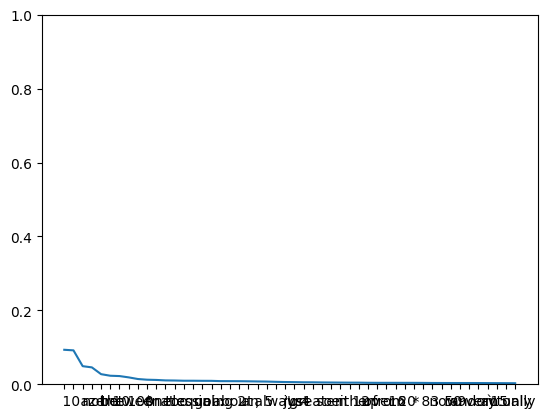

In [302]:
plt.plot([tokenizer70m.decode(toks_base[i]) for i in range(len(toks_base))], tok_probs_base)
plt.ylim((0,1))

(0.0, 1.0)

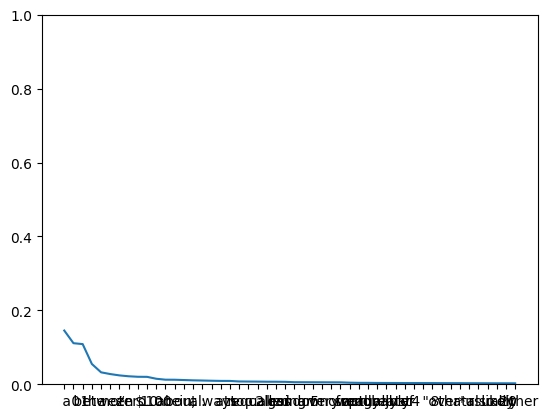

In [303]:
plt.plot([tokenizer70m.decode(toks_sft[i]) for i in range(len(toks_sft))], tok_probs_sft)
plt.ylim((0,1))

(0.0, 1.0)

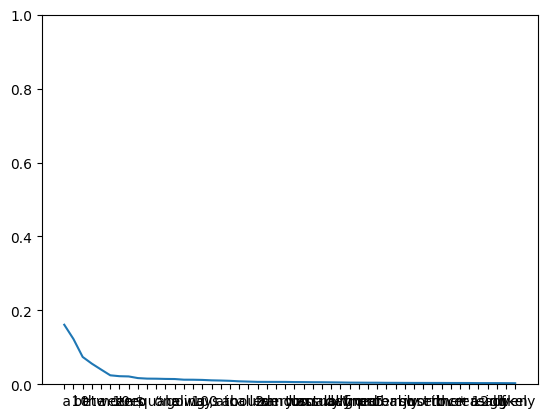

In [301]:
plt.plot([tokenizer70m.decode(toks_dpo[i]) for i in range(len(toks_dpo))], tok_probs_dpo)
plt.ylim((0,1))